# MFM simulations

Phase shift of Magnetic Force Microscopy cantilever
\begin{equation}
    \Delta \phi = \frac{Q\mu_0}{k} \left( q \frac{\partial {\bf H}_{sz}}{\partial z} + {\bf M}_t \cdot \frac{\partial^2{\bf H}_{s}}{\partial z^2} \right). \label{Eq:C7:MFM_phase_Full}
\end{equation}

where (I will assume the tip is a delta function for now),
$Q$ is the quality factor of the cantilever,
$k$ is the spring constant of the cantilever,
$q$ is the magnetic monopole moment of the tip,
${\bf M}_t$ is the magnetic dipole moment of the tip and,
${\bf H}_{sz}$ is the magnetic field due to the sample.


### Importing Packages

In [125]:
Ms = 1.1e6
region = df.Region(p1=(-50e-9, 0, -1e-9), p2=(50e-9, 10e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(1e-9, 1e-9, 1e-9))

def m_fun(pos):
    x, y, z = pos
    q = 10e-9
    mz = -2*Ms/np.pi * np.arctan(x/q) 
    mx = Ms - mz
    return [mx, 0, mz]

    
field = df.Field(mesh, dim=3, value=m_fun)
system = mm.System(name='Box2')
system.energy = mm.Demag()
system.m = field

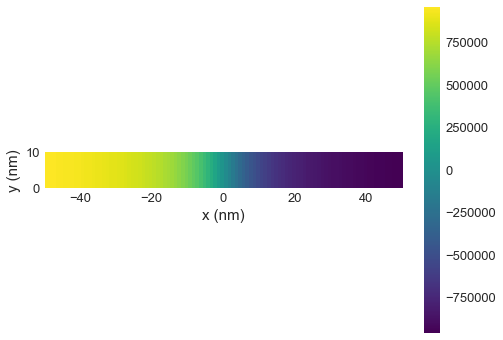

In [126]:
field.z.plane(z=-1e-9).mpl()

In [127]:
phase = mag2exp.mfm.phase_shift(system, tip_m=(0,0,1e-16))

cut = phase.array[:,0,0,0]

Running OOMMF (DockerOOMMFRunner) [2021/08/05 15:29]... (3.4 s)


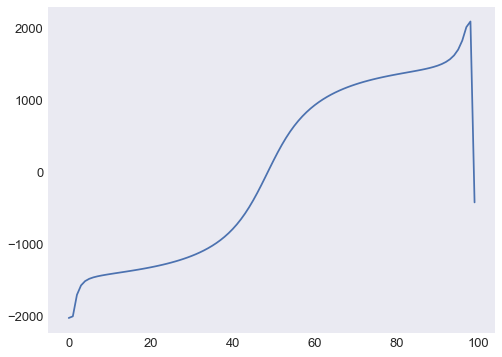

In [128]:
plt.plot(cut)

In [ ]:
def analytical_sol(pos):
    x, y, z = pos
    q = 30e-9
    a = 1e-9
    analytical = Ms*np.cos(2*np.pi*x/q)*1e-7*4*np.pi*np.log(1/(z-1e-9))
    return analytical
an_phase = df.Field(phase.mesh, dim=1, value=analytical_sol)
an_cut = an_phase.line(p1=(30e-9, 50e-9, 5e-09),
                           p2=(120e-9, 50e-9, 5e-09),
                           n=90)
plt.plot(cut.data['v'].to_numpy())
plt.plot(an_cut.data['v'].to_numpy())

In [81]:
Ms = 1.1e6
region = df.Region(p1=(0, 0, -1e-9), p2=(150e-9, 100e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(1e-9, 1e-9, 1e-9))

def m_fun(pos):
    x, y, z = pos
    q = 30e-9
    return [0, np.sin(2*np.pi*x/q), np.cos(2*np.pi*x/q)]

def norm_fun(pos):
    x, y, z = pos
    if z < 0:
        return Ms
    else:
        return 0
    
field = df.Field(mesh, dim=3, value=m_fun, norm=norm_fun)

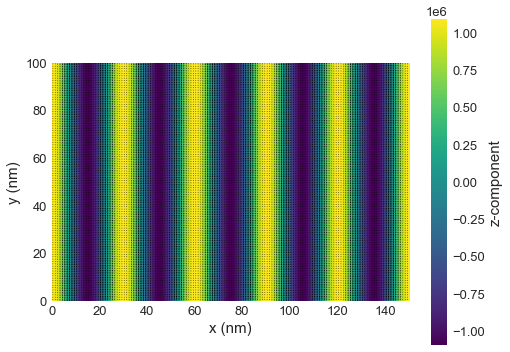

In [82]:
field.plane(z=-1e-9).mpl()

In [83]:
system = mm.System(name='Box2')
system.energy = mm.Demag()
system.m = field

In [84]:
phase = mag2exp.mfm.phase_shift(system, tip_m=(0,0,1e-16))


cut = phase.line(p1=(30e-9, 50e-9, 5e-09),
                 p2=(120e-9, 50e-9, 5e-09), n=90)

Running OOMMF (DockerOOMMFRunner) [2021/08/05 14:54]... (5.8 s)


In [85]:
import matplotlib.pyplot as plt

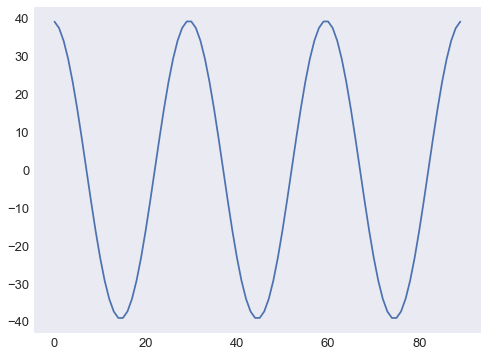

In [86]:
plt.plot(cut.data['v'].to_numpy())

<ipython-input-106-6c960c4d8538>:5: RuntimeWarning: invalid value encountered in log
  analytical = Ms*np.cos(2*np.pi*x/q)*1e-7*4*np.pi*np.log(1/(z-1e-9))


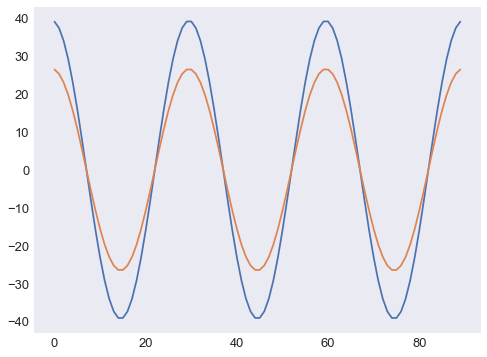

In [106]:
def analytical_sol(pos):
    x, y, z = pos
    q = 30e-9
    a = 1e-9
    analytical = Ms*np.cos(2*np.pi*x/q)*1e-7*4*np.pi*np.log(1/(z-1e-9))
    return analytical
an_phase = df.Field(phase.mesh, dim=1, value=analytical_sol)
an_cut = an_phase.line(p1=(30e-9, 50e-9, 5e-09),
                           p2=(120e-9, 50e-9, 5e-09),
                           n=90)
plt.plot(cut.data['v'].to_numpy())
plt.plot(an_cut.data['v'].to_numpy())

In [103]:
np.log(1e9)

20.72326583694641

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import matplotlib.pyplot as plt
import mag2exp
import matplotlib.colors

### Magnetisation data

Perform micromagnetic simulation or load from file.

In [17]:
region = df.Region(p1=(-0e-9, -0e-9, -0e-9), p2=(50e-9, 50e-9, 50e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=8.78e-12)
               + mm.DMI(D=3e-3, crystalclass='T') #1.58e-3
               #+ mm.UniaxialAnisotropy(K=0.8e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 10e4)))

In [18]:
Ms = 384e3

    
def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero above the sample,
    Ms inside sample.

    Sample thickness is 50nm.

    """
    x, y, z = pos
    if (z < 0):
        return Ms
    else:
        return 0
    
def m_t_q(pos):
    """
    Function to make a tripple q structure with a period of 50 nm
    
    """
    q = 2*np.pi/(50e-9)
    x, y, z = pos
    
    m_x = 1*(np.sqrt(3)/3)*(- (np.sqrt(3)/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            + (np.sqrt(3)/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)))
    m_y = 1*(np.sqrt(3)/3)*(np.sin(q*(x)) 
                            - (1/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            - (1/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)) )
    m_z = (1+ 1*(np.sqrt(3)/3)*(-np.cos(q*(x))
                                - np.cos(q*(-0.5*x+np.sqrt(3)*y/2))
                                - np.cos(q*(-0.5*x-np.sqrt(3)*y/2))))
    return (m_x, m_y, m_z)

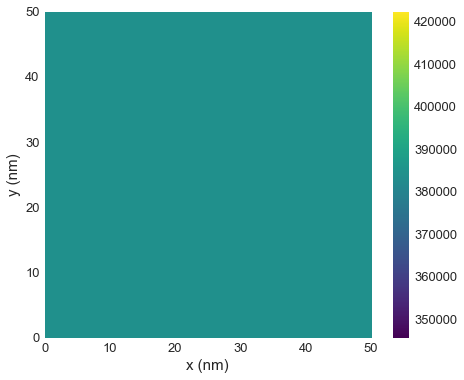

In [20]:
system.m = df.Field(mesh, dim=3, value=(0,0,1), norm=Ms)
system.m.z.plane('z').mpl()

In [21]:
demag_oc = oc.compute(system.energy.demag.effective_field, system)

Running OOMMF (DockerOOMMFRunner) [2021/08/05 10:39]... (3.1 s)


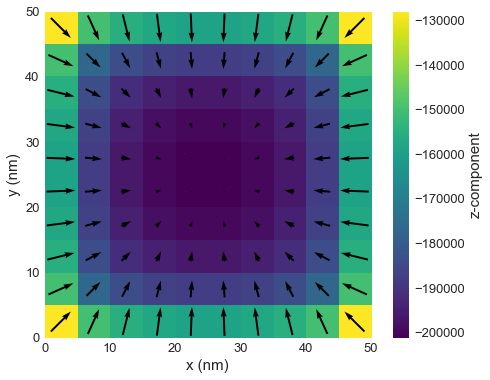

In [22]:
demag_oc.plane(z=0e-9).mpl()

In [23]:
import discretisedfield.tools as dft

In [ ]:
s

In [24]:
demagt = dft.demag_tensor_numpy(system.m.mesh)
demag_df = dft.demag_field(system.m, demagt)

In [45]:
demagt.array[..., 4].sum()

(0.14526332608724737-7.771561172376096e-16j)

In [27]:
np.allclose(demag_df.array, demag_oc.array, rtol=1e-1)

True

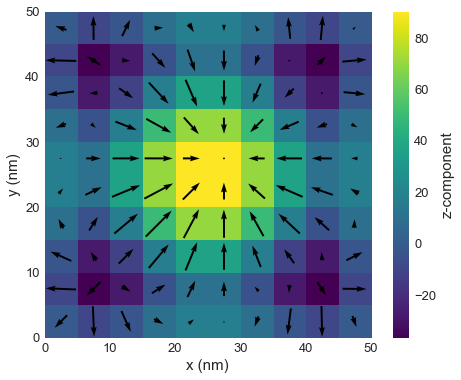

In [26]:
(demag_df-demag_oc).plane('z').mpl()

\begin{array}
    H &= \frac{1}{\mu_0}B - M \\
     & = \frac{1}{\mu_0} \nabla \times A - M \\
\end{array}

In [13]:
def demag_mvp(field):
    m_pad= field.pad(pad_width={'x': (0, field.mesh.n[0]),
                                   'y': (0, field.mesh.n[1]),
                                   'z': (0, field.mesh.n[2])}, mode='constant')
    mft = m_pad.rfftn
    k = df.Field(mesh=mft.mesh, dim=3, value=lambda x: x)
    k2 = k @ k + 1e-11
    demag_ft = -mft + ((1/(1)) * k & (mft & k) / k2)
    demag = demag_ft.irfftn
    demag = df.Field(mesh=mesh, dim=3, value=demag.array[0:system.m.mesh.n[0],0:system.m.mesh.n[1],0:system.m.mesh.n[2],:])
    return demag

In [14]:
demag_fft = demag_mvp(system.m)

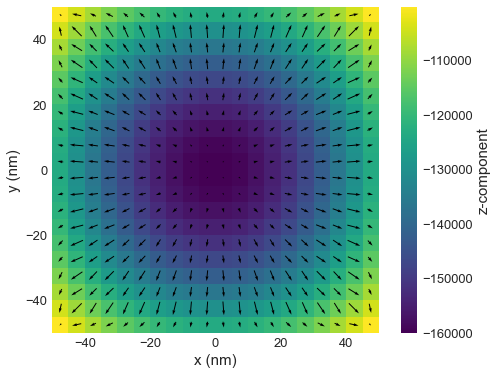

In [16]:
demag_fft.plane('z').mpl()

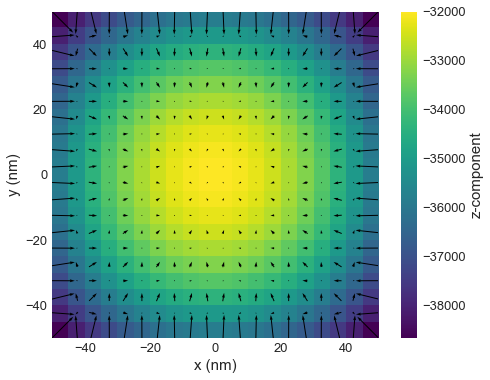

In [15]:
(demag_fft-demag_oc).plane('z').mpl()

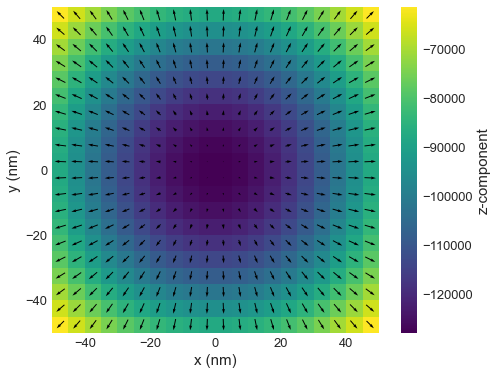

In [32]:
demag3.plane('z').mpl()

In [39]:
np.allclose(demag3.array, demag.array)

True

In [34]:
demag.mesh

Mesh(region=Region(p1=(-5e-08, -5e-08, -5e-08), p2=(5e-08, 5e-08, 5e-08)), n=(20, 20, 20), bc='', subregions={}, attributes={'unit': 'm', 'fourierspace': False, 'isplane': False})

In [ ]:
system.m.plane('x').mpl()

In [ ]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

In [ ]:
system.m.z.plane(z=5e-9).mpl()

### MFM Calculation

Phase shift of Magnetic Force Microscopy cantilever
\begin{equation}
    \Delta \phi = \frac{Q\mu_0}{k} \left( q \frac{\partial {\bf H}_{sz}}{\partial z} + {\bf M}_t \cdot \frac{\partial^2{\bf H}_{s}}{\partial z^2} \right). \label{Eq:C7:MFM_phase_Full}
\end{equation}

where (I will assume the tip is a delta function for now),
$Q$ is the quality factor of the cantilever,
$k$ is the spring constant of the cantilever,
$q$ is the magnetic monopole moment of the tip,
${\bf M}_t$ is the magnetic dipole moment of the tip and,
${\bf H}_{sz}$ is the magnetic field due to the sample.


In [ ]:
phase = mag2exp.mfm.phase_shift(system, Q=650, k=3, tip_m=(0,0,1e-13))

In [ ]:
gf_3d = mag2exp.util.gaussian_filter(phase, fwhm=[15e-9, 15e-9, 0])
gf_3d.plane(z=50e-9).mpl()

In [ ]:
phase.plane(z=50e-9).mpl_scalar()

Calculate stray field (does this give the stray field when an external field is also applied?)

Need to think about convolutions with a tip function? And proper normalisation!

In [ ]:
conv_mag2exp = mag2exp.util.gaussian_filter(phase.plane(z=50e-9), fwhm=[15e-9, 15e-9])

In [ ]:
(conv_mag2exp - gf_3d.plane(z=50e-9)).mpl()

In [ ]:
phase = mag2exp.mfm.phase_shift(system, Q=650, k=3, tip_m=(0,0,1e-13), fwhm=(15e-9, 15e-9, 0))

In [ ]:
phase.plane(z=50e-9).mpl_scalar()

In [ ]:
boundaries = sorted(phase.array.flat)[:: len(phase.array.flat)//100][:-1] + [np.max(phase.array.flat)]
@df.interact(x=system.m.mesh.slider('x'))
def plot(x):
    conv_mag2exp = phase.plane(x=x)
    conv_mag2exp.mpl_scalar(norm=matplotlib.colors.BoundaryNorm(boundaries=boundaries, ncolors=256))

In [ ]:
region = df.Region(p1=(0,0,5e-9), p2=(150e-9,150e-9,100e-9))
sub_phase = phase[region]

boundaries = sorted(sub_phase.array.flat)[:: len(sub_phase.array.flat)//100][:-1] + [np.max(sub_phase.array.flat)]
@df.interact(x=system.m.mesh.slider('x'))
def plot(x):
    conv_mag2exp = sub_phase.plane(x=x)
    conv_mag2exp.mpl_scalar(norm=matplotlib.colors.BoundaryNorm(boundaries=boundaries, ncolors=256))